In [88]:
import numpy as np
import matplotlib.pylab as plt
import camb

In [89]:
stuff=np.load('mcmc/sidebands.npz')
t=stuff['time']
d=stuff['signal']

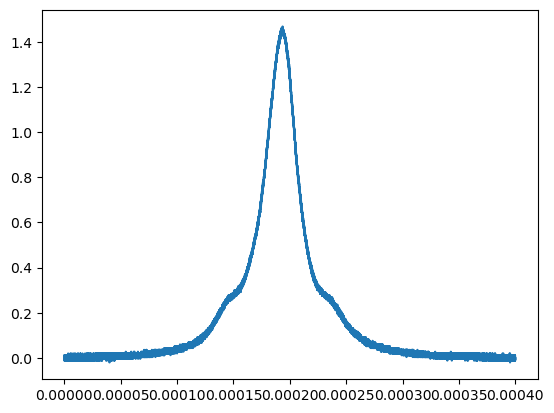

In [90]:
plt.plot(t,d)

# Gradient
Here we take gradient by inspection to get analytical forms (could have used method from PS-1).
$$
\begin{aligned}
\partial_a \text{lor} &=\frac{1}{\frac{\left(t-t_0\right){}^2}{w^2}+1}\\
\partial_{t_0} &= \frac{2 \left(t-t_0\right)}{t^2-2 t_0 t+t_0^2+w^2}\cdot \text{lor}\\
\partial_w &= \frac{2}{w}-\frac{2 w}{t^2-2 t_0 t+t_0^2+w^2}\cdot \text{lor}
\end{aligned}
$$


Here, we borrow Jon's in-class code for non-linear square fitting. The method is based on Newton's method by solving for $\nabla\chi^2 =0 $ iteratively.

Every iteration, update the parameter $m=m+\delta m$. $\delta m$ can be solved by 
$$
A_m N^{-1}A_m \delta m = A_m N^{-1}r$$, where $$r = d - A(m), A_m = \frac{\partial A}{\partial m}$$
We recognize the left-hand side with two $\nabla's$ as the "curvature matrix" `curv_mat`


In [91]:
def lor(p, t): 
    a, t0 , w = p
    return a / (1 + ((t - t0) / w)**2)


def calc_lor(p,t):
    a, t0, w = p
    y = lor(p, t)
    grad = np.zeros([len(t), len(p)])
    
    grad[:,0] = 1.0 / (1 + (t-t0)**2 / w**2)
    grad[:,1] = (2 * (t-t0) / (t**2 - 2 * t0 * t + t0**2 + w**2) ) * y
    grad[:,2] = (2 / w - 2 * w / (t**2 - 2 * t0 * t + t0**2 + w**2)) * y 
    return y , grad


Here we assume that $N$ is the identity matrix (errors are identical).
# Rescaled the x-axis by $10^4$

[1.42281068e+00 1.92358649e-04 1.79236908e-05]


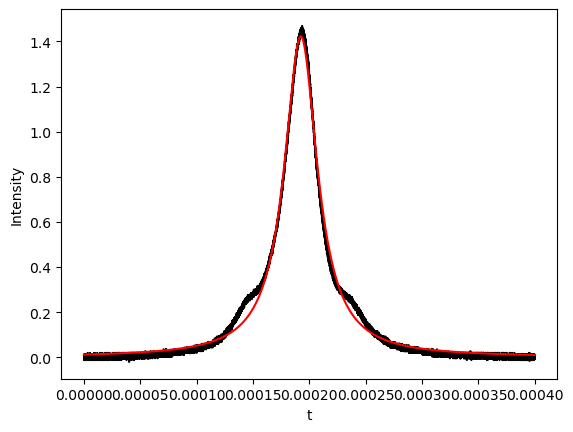

In [92]:
steps = 100

p0 = np.array([1.4, 2.0e-4, .5e-4])
p = p0.copy()

for i in range(steps):
    pred, grad = calc_lor(p,t)
    r = d - pred
    # #     err=(r**2).sum()
    r = np.matrix(r).transpose()
    grad = np.matrix(grad)

    lhs = grad.transpose() @ grad
    rhs = grad.transpose() @ r
    curv_mat = np.linalg.inv(lhs)
    dp = curv_mat@(rhs)
    for j in range(len(p)):
        p[j] = p[j] + dp[j]

plt.plot(t, d, 'k--', label = 'Data')
plt.plot(t, pred, 'r-', label = 'Newtonian Fit')
plt.xlabel('t')
plt.ylabel('Intensity')
print(p)

# Estimate Error in the data
Here we use rms_err as a guess for the actual noise in our data. This is a very rough guess. 
For Gaussian statistics, we can get the standard deviations from curvature. Here, we calculate the curvature matrix:

$$\frac{1}{\sigma_{i,j}^2}=A_m^T N^{-1}A_m $$

But because $N$ is a diagonal matrix (assuming uncorrelated noise), this is simply:

$$\frac{1}{\sigma_{i,j}^2}=\frac{1}{\text{RMS noise}^2}A_m^T A_m$$

**NOTE: previously `curv_mat` did not contain information about the error. We assumed it was the identity matrix**

In [93]:
rms_err = np.std(d-pred)
p_err = np.sqrt(np.diag(curv_mat * rms_err**2))
print(p)
print(p_err)

[1.42281068e+00 1.92358649e-04 1.79236908e-05]
[4.22291326e-04 5.31820045e-09 7.53124668e-09]


# Numerical Derivative

Modifying the central difference formula from A1. We differentiate the variables inside x. 

In [94]:
def Ndiff(f, x):
    diffs = []
    dx = 1e-8

    for i in range(len(x)):
        one_idx = np.zeros(len(x))
        one_idx[i] += 1
        
        x_2m = x.copy()
        x_m  = x.copy()
        x_p  = x.copy()
        x_2p = x.copy()
        x_2m -= 2 *dx * one_idx
        x_m  -= dx * one_idx
        x_p  += dx * one_idx
        x_2p += 2*dx * one_idx
        
        diffs.append((f(x_2m) + 8 * f(x_p) - 8 * f(x_m) - f(x_2p))/(12 * dx))
#         diffs.append((f(x_p)- f(x_m))/(2*dx))

    return np.array(diffs)

In [95]:
def lor(p, t): 
    a, t0 , w = p
    return a / (1 + ((t - t0) / w)**2)

def Ncalc_lor(p, t):
    a, t0, w = p
    y = lor(p, t)
    grad = np.zeros([len(t), len(p)])
    
    llor = lambda p: lor(p, t)
    grad = Ndiff(llor, p).transpose()
    
    return y , grad

[1.42281068e+00 1.92358649e-04 1.79236908e-05]


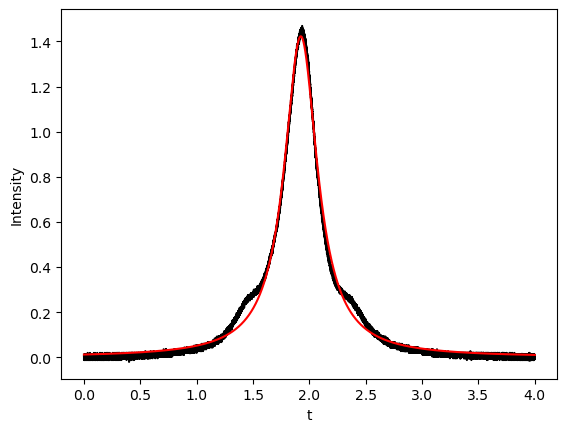

In [96]:
steps = 10

p0 = np.array([1.4, 2.0e-4, .5e-4])
Np = p0.copy()

for i in range(steps):
    pred, grad = Ncalc_lor(Np,t)
    r = d - pred
    # #     err=(r**2).sum()
    r = np.matrix(r).transpose()
    grad = np.matrix(grad)

    lhs = grad.transpose() @ grad
    rhs = grad.transpose() @ r
    curv_mat = np.linalg.inv(lhs)
    dp = curv_mat@(rhs)
    for j in range(len(Np)):
        Np[j] = Np[j] + dp[j]

plt.plot(t*1e4, d, 'k--', label = 'Data')
plt.plot(t*1e4, pred, 'r-', label = 'Newtonian Fit')
plt.xlabel('t')
plt.ylabel('Intensity')
print(p)

<!-- # Comparison
The answer from a) was:
`[1.42281068 1.92358649 0.17923691]`

The answer using numerical differentiation is :

`[1.42281068 1.92358649 0.17923691]`

They are identical. -->

In [97]:
print("Fit using exact diff:".rjust(30),p)
print("Fit using N diff:".rjust(30), Np)
print("Uncertainty (exact diff.):".rjust(30),p_err,"\n\n")
print("Difference: ".rjust(30), p-Np)

         Fit using exact diff: [1.42281068e+00 1.92358649e-04 1.79236908e-05]
             Fit using N diff: [1.42281068e+00 1.92358649e-04 1.79236908e-05]
    Uncertainty (exact diff.): [4.22291326e-04 5.31820045e-09 7.53124668e-09] 


                  Difference:  [-2.27300401e-11 -1.39591030e-16  5.32427970e-16]


# Comparison
The two answers are identical and they agree fully within statistical uncertainties (with our simple noise model...).

# Fitting with Three Lorentzians 

In [98]:
def tri(p, t):
    a, b, c, t0, w, dt = p
    return a/(1 + (t-t0)**2 / w**2) + b/(1 + (t-t0+dt)**2 / w**2) + c/(1 + (t-t0-dt)**2 / w**2)


def calc_tri(p, t):
    y = tri(p, t)
    grad = np.zeros([len(t), len(p)])
    
    lor3 = lambda p: tri(p, t)
    grad = Ndiff(lor3, p).transpose()
    
    return y , grad

Text(0, 0.5, 'Intensity')

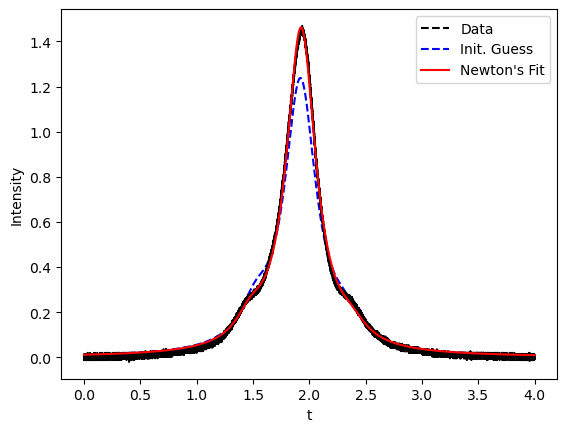

In [99]:
steps = 100

p0 = np.array([1.2, .15, .1, 1.92e-4, 1.7e-5, 4e-5])
p = p0.copy()

for i in range(steps):
    pred, grad = calc_tri(p,t)
    r = d - pred
    r = np.matrix(r).transpose()
    grad = np.matrix(grad)

    lhs = grad.transpose() @ grad
    rhs = grad.transpose() @ r
    curv_mat = np.linalg.inv(lhs)
    dp = curv_mat@(rhs)
    for j in range(len(p)):
        p[j] += dp[j]
    
plt.plot(t*1e4, d, 'k--', label = 'Data')
plt.plot(t*1e4, calc_tri(p0, t)[0], 'b--', label = "Init. Guess", zorder = -1)
plt.plot(t*1e4, pred, 'r-', label = 'Newton\'s Fit')
plt.legend()
plt.xlabel('t')
plt.ylabel('Intensity')

In [100]:
print('Fitted params: \n'.ljust(30), p)

rms_err = np.sqrt(np.sum((d-pred)**2)/len(d))
print("\nRMS error:".ljust(30), rms_err,"\n")
p_err = np.sqrt(np.diag(curv_mat * rms_err**2))
print('Uncertainties: \n'.ljust(30), p_err)

Fitted params: 
               [1.44299240e+00 1.03910783e-01 6.47325292e-02 1.92578522e-04
 1.60651094e-05 4.45671634e-05]

RMS error:                    0.01457644476006902 

Uncertainties: 
               [2.66428694e-04 2.54116769e-04 2.48823333e-04 3.15440252e-09
 5.64926768e-09 3.80268482e-08]


# Residuals

Text(0.5, 0, 't')

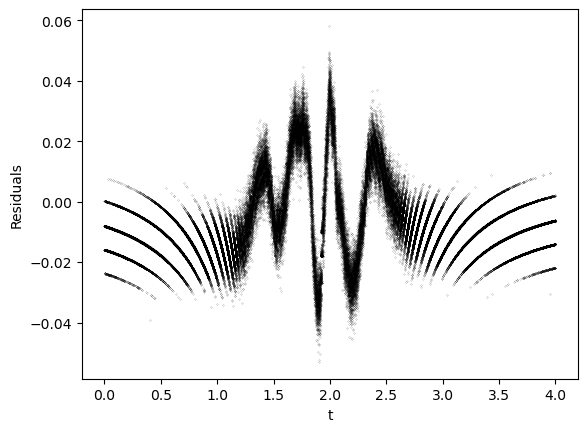

In [101]:
plt.plot(t*1e4, d-pred, 'k.', ms = .2)
plt.ylabel('Residuals')
plt.xlabel('t')

Previously, we substituted the RMS error for the real noise. The RMS error was about `0.0145`. From the residual plot, the noise (assuming uniform and uncorrelated) is on the order of `.02`. 

Therefore, I believe in the errorbars I got (up to one order of magnitude).

**However, the model is NOT a complete description of the data. The residual plot wiggles around the center, and we need further explanation for that.**

# Correlated Noise
We can generate correlated noise using Cholesky decomposition on the **covariance** matrix: $A_m^T N^{-1}A_m$. This tells us about the covariance around the $\chi^2$ minimum. 

We can rotate from uncorrelated Gaussians to correlated parameter errors via: $$L\delta \vec{x} = \delta \vec{m}$$

## Again, including RMS noise as $N^{-1}$
**Assuming independence and uniform, we need to add RMS information in our Cholesky decomposition.**

Here I plotted the residuals because the the plots are almost identical.

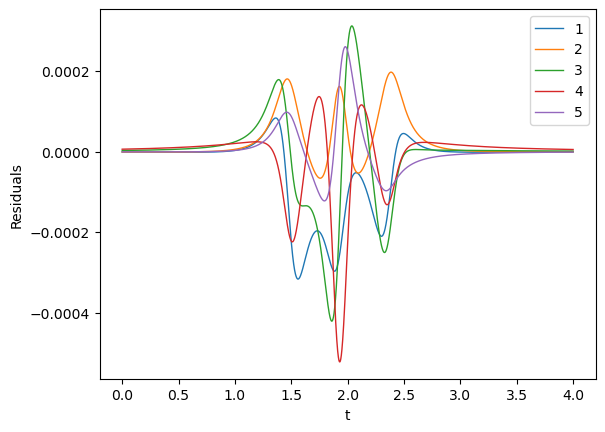

In [102]:
L = np.linalg.cholesky(curv_mat * rms_err**2)

for i in range(5):
    p_rand = p + L@np.random.randn(len(p))
    p_rand = p_rand.tolist()[0]
    plt.plot(t*1e4, calc_tri(p_rand, t)[0] - calc_tri(p, t)[0], lw = 1, label = f"{i+1}")
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('Residuals')

## $\chi^2$ comparison

Note that we need to account for the RMS error here since we generated our parameters with it. 

In [103]:
chi2 = np.sqrt(np.sum((d - pred)**2/rms_err**2))
chi2

316.2277660168379

# Correlated error
Cholesky decomposition couples the changes in different input parameters, and we can generate steps with regards to covariances of the variables. (more accurate way of doing things).

In [104]:
L = np.linalg.cholesky(curv_mat * rms_err**2)

chi_rand = []

for i in range(200):
    p_rand = p + L@np.random.randn(len(p))
    p_rand = p_rand.tolist()[0]
    chisqr = np.sqrt(np.sum((calc_tri(p_rand, t)[0] - d)**2/(rms_err**2)))
    chi_rand.append(chisqr)

Average value of chi^2:  316.237549486681
Average Difference between random chi^2 and best fit:  0.00978346984311429
STD chi^2:  0.0055062877473682995


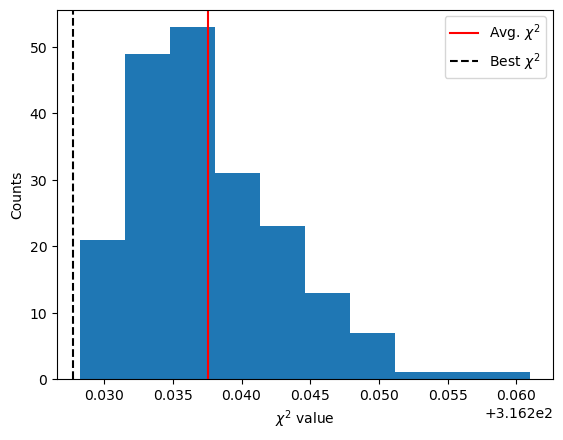

In [105]:
plt.hist(chi_rand, histtype = 'stepfilled');
plt.xlabel('$\chi^2$ value')
plt.ylabel('Counts')
plt.axvline(np.mean(chi_rand), c='r', label = 'Avg. $\chi^2$')
plt.axvline(chi2, c='k', ls = '--',label = 'Best $\chi^2$')
plt.legend()
print("Average value of chi^2: ", np.mean(chi_rand))
print("Average Difference between random chi^2 and best fit: ", np.mean(chi_rand) - chi2)
print("STD chi^2: ", np.std(chi_rand))

(Despite that applying the idea of $\sigma$ to $\chi^2$ distribution is a bit of a stretch, I suppose?)
The best fit $\chi^2$ is **within $2\sigma$** to the mean of $\chi^2$ distributions. Therefore, it is reasonable. 

Our best $\chi^2$ value is below average because of the fact that we are **perturbed out of minima**.

# MCMC
Routine:

* Start @ some position in parameter space
    
* Generate normal moves in parameter space 

    * stepsizes to proportional uncertainties previously calculated
    
* Use exponential $\delta \chi^2$ to reject

Target acceptance rate: $20\%-25\%$

In [106]:
stepsizes = np.sqrt(np.diag(curv_mat * rms_err**2))
stepsizes

array([2.66428694e-04, 2.54116769e-04, 2.48823333e-04, 3.15440252e-09,
       5.64926768e-09, 3.80268482e-08])

In [117]:
def chi2(params):
    chisqr = np.sqrt(np.sum((tri(params, t) - d)**2))/rms_err
    return chisqr

steps = 100000
scaling = 20


pp = [1.44299240e+00, 1.03910783e-01, 6.47325292e-02,1.92578522e-04,1.60651094e-05,4.45671634e-05]
chisqr = chi2(pp)

chain = np.zeros([steps, len(pp)])
chi2L = np.zeros(steps)


for s in np.arange(steps):
    p_new = pp + np.random.randn(6) * stepsizes * scaling
    new_chi2 = chi2(p_new)
    
    del_chi = new_chi2 - chisqr
    
    take = None
    
    if del_chi >= 0 :
        if np.random.rand() < np.exp(- 0.5 * del_chi):
            take = True
            
        else:
            take = False
            
    if del_chi < 0:
        take = True
    
    if take == True:
        pp = p_new            
        chisqr = new_chi2
        
    chi2L[s] = chisqr
    chain[s, :] = pp
            
            
    

In [118]:
np.save('mcmc/chain.npy',chain)
chain = np.load('mcmc/chain.npy')

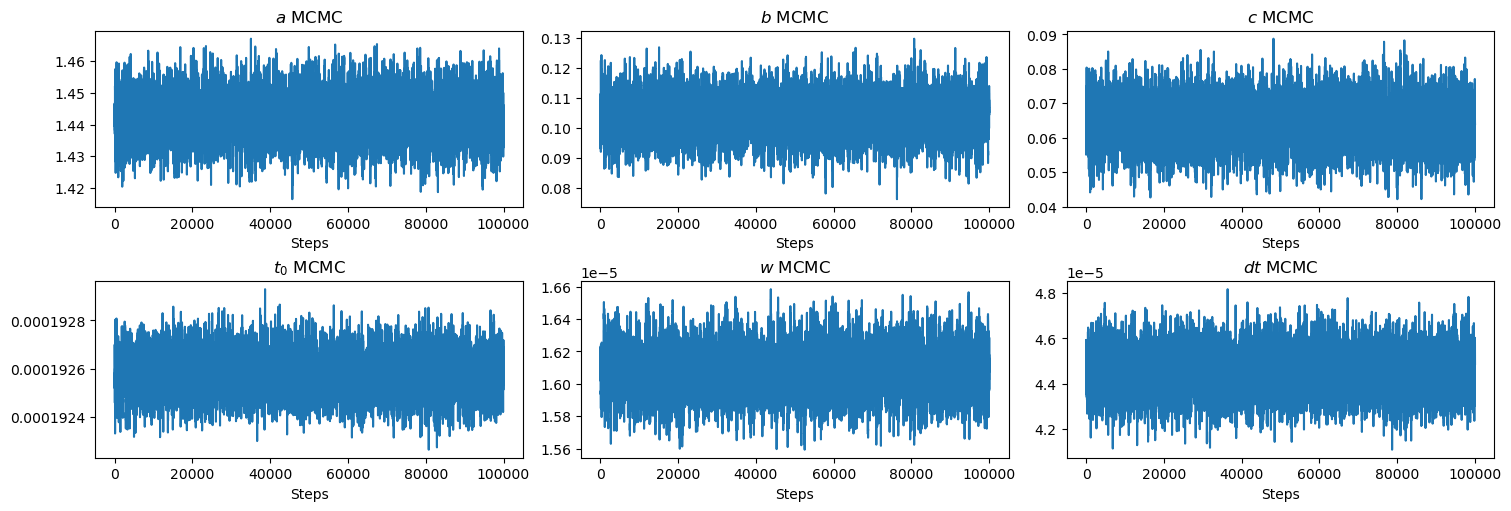

In [119]:
fig = plt.figure(figsize = (15,5),constrained_layout = True)
axes = fig.subplots(2,3).flatten()

pname = ["a","b","c", "t_0", "w", "dt"]

for i in np.arange(6):
    axes[i].plot(chain[:, i])
    # plt.title('Peak Center')
    axes[i].set_xlabel('Steps')
    axes[i].set_title(f"${pname[i]}$ MCMC")

<Figure size 640x480 with 0 Axes>

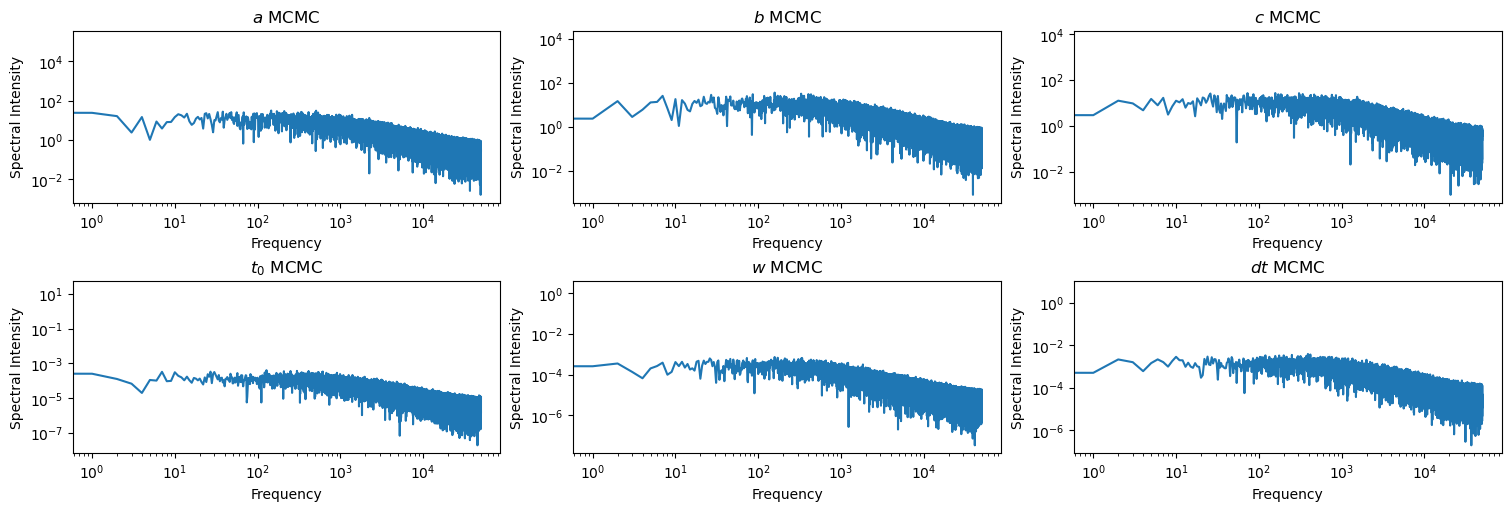

In [120]:
plt.clf()
fig2 = plt.figure(figsize = (15,5),constrained_layout = True)
axes2 = fig2.subplots(2,3).flatten()

pname = ["a","b","c", "t_0", "w", "dt"]

for i in np.arange(6):
    freq = np.fft.rfftfreq(chain[:,i].shape[-1])
    axes2[i].loglog(np.abs(np.fft.rfft(chain[:,i])))
    axes2[i].set_xlabel('Frequency')
    axes2[i].set_ylabel('Spectral Intensity')
    axes2[i].set_title(f"${pname[i]}$ MCMC")


## Power spectrum is more or less frequency independent (except locally at high frequency) which is a good sign for convergence.

## Acceptance rate

In [126]:
(len(chi2L) - np.sum((np.diff(chi2L)==0)))/len(chi2L)

0.2381

# Convergence
From the above plots, we see that the $\chi^2$ time-series does not show structures. DFT does not show any clear structure either. Therefore, we can conclude that the MCMC has converged.

In [127]:
print("Fit using MCMC:".rjust(30), chain[np.argmin(chi2L)])
print("Uncertainty using MCMC:".rjust(30),np.std(chain,axis = 0),"\n\n")
print("Miminum chi^2 MCMC:".rjust(30), np.min(chi2L),"\n\n")
chimin = np.min(chi2L)

               Fit using MCMC: [1.44299240e+00 1.03910783e-01 6.47325292e-02 1.92578522e-04
 1.60651094e-05 4.45671634e-05]
       Uncertainty using MCMC: [6.65804576e-03 6.43037263e-03 6.14258386e-03 8.11772477e-08
 1.37358915e-07 8.93825404e-07] 


           Miminum chi^2 MCMC: 316.2277660168436 




### Look at region where $\Delta \chi^2$ is less than 1 from $\text{min}\{\chi^2\}$

In [128]:
contain = np.array([chi2L - chimin <1])[0]

mcmc_p = np.mean(chain[contain], axis = 0)
mcmc_err = np.std(chain[contain], axis = 0)
print("Fit with del-chi^2 < 1:\n".ljust(30), mcmc_p,"\n")
print("Uncertainty with del-chi^2 < 1:\n".ljust(30), mcmc_err )

Fit with del-chi^2 < 1:
       [1.44301041e+00 1.03795250e-01 6.44859026e-02 1.92575724e-04
 1.60692204e-05 4.46048665e-05] 

Uncertainty with del-chi^2 < 1:
 [2.29900978e-03 2.10407703e-03 2.06659060e-03 2.93349289e-08
 4.95415550e-08 3.54818214e-07]


## Compare with NLS fitting
The error bars are about one order of magnitude larger than using NLS fitting if we look at region where $\delta \chi^2$ is less than one.

In [129]:
print("NLS fitting:".ljust(30), p)
print("Uncertainty:".ljust(30),p_err,"\n\n")

NLS fitting:                   [1.44299240e+00 1.03910783e-01 6.47325292e-02 1.92578522e-04
 1.60651094e-05 4.45671634e-05]
Uncertainty:                   [2.66428694e-04 2.54116769e-04 2.48823333e-04 3.15440252e-09
 5.64926768e-09 3.80268482e-08] 




# Resonance Width
$$\frac{dx}{9 \text{ GHz}}= \frac{w}{\text{res.freq. width}}$$ 


In [130]:
real_w = 9/mcmc_p[-1] *mcmc_p[-2] # in GHz
err_real_w = np.sqrt((9/mcmc_p[-1] * mcmc_err[-2])**2 + (9/mcmc_p[-1]**2 * mcmc_p[-2] *mcmc_err[-1])**2)
print("Resonance width is: ", f"{real_w:.2f}","+/-", f"{err_real_w:.2f}","GHz")

Resonance width is:  3.24 +/- 0.03 GHz
